In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [16]:
K.shape

(9571,)

In [3]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_lr_chh_rois.npy')
K = np.load('/home/ali/RadDBS-QSM/data/npy/old/K_chh.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_lr_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
K = K.reshape(n_cases,n_rois,n_features-1)
X_all_c = X_all_c[:,:,:]
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [9]:
K[-1]

'pre_updrs_off'

In [4]:
per_change

array([0.71698113, 0.46875   , 0.68965517, 0.41935484, 0.14705882,
       0.43859649, 0.88      , 0.39534884, 0.59677419, 0.8125    ,
       0.63829787, 0.71641791, 0.30769231, 0.68      , 0.33802817,
       0.58823529, 0.93877551, 0.83673469, 0.09677419, 0.41463415,
       0.57142857, 0.6557377 , 0.62820513, 0.47058824, 0.28333333,
       0.59493671, 0.52941176, 0.86046512, 0.48148148, 0.6557377 ,
       0.33333333, 0.49462366, 0.77777778, 0.80701754, 0.71428571,
       0.31521739, 0.83333333])

In [5]:
pre_updrs_iii_off

array([ 53.,  32.,  58.,  62.,  34.,  57., 100.,  43.,  62.,  64.,  94.,
        67.,  26.,  25.,  71.,  51.,  49.,  49.,  31.,  41.,  35.,  61.,
        78.,  51.,  60.,  79.,  85.,  43.,  54.,  61.,  54.,  93.,  54.,
        57.,  49.,  92.,  54.])

In [6]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [7]:
X = X_all_c.reshape(X_all_c.shape[0],-1)
K = K.reshape(K.shape[0],-1)
X = np.append(X,pre_updrs_off.reshape(-1,1),axis=1)
K = np.append(K[0],['pre_updrs_off'],axis=0)
scaler = skp.StandardScaler()
X0_ss0 = scaler.fit_transform(X)

pre_updrs_off 0.403 0.01328


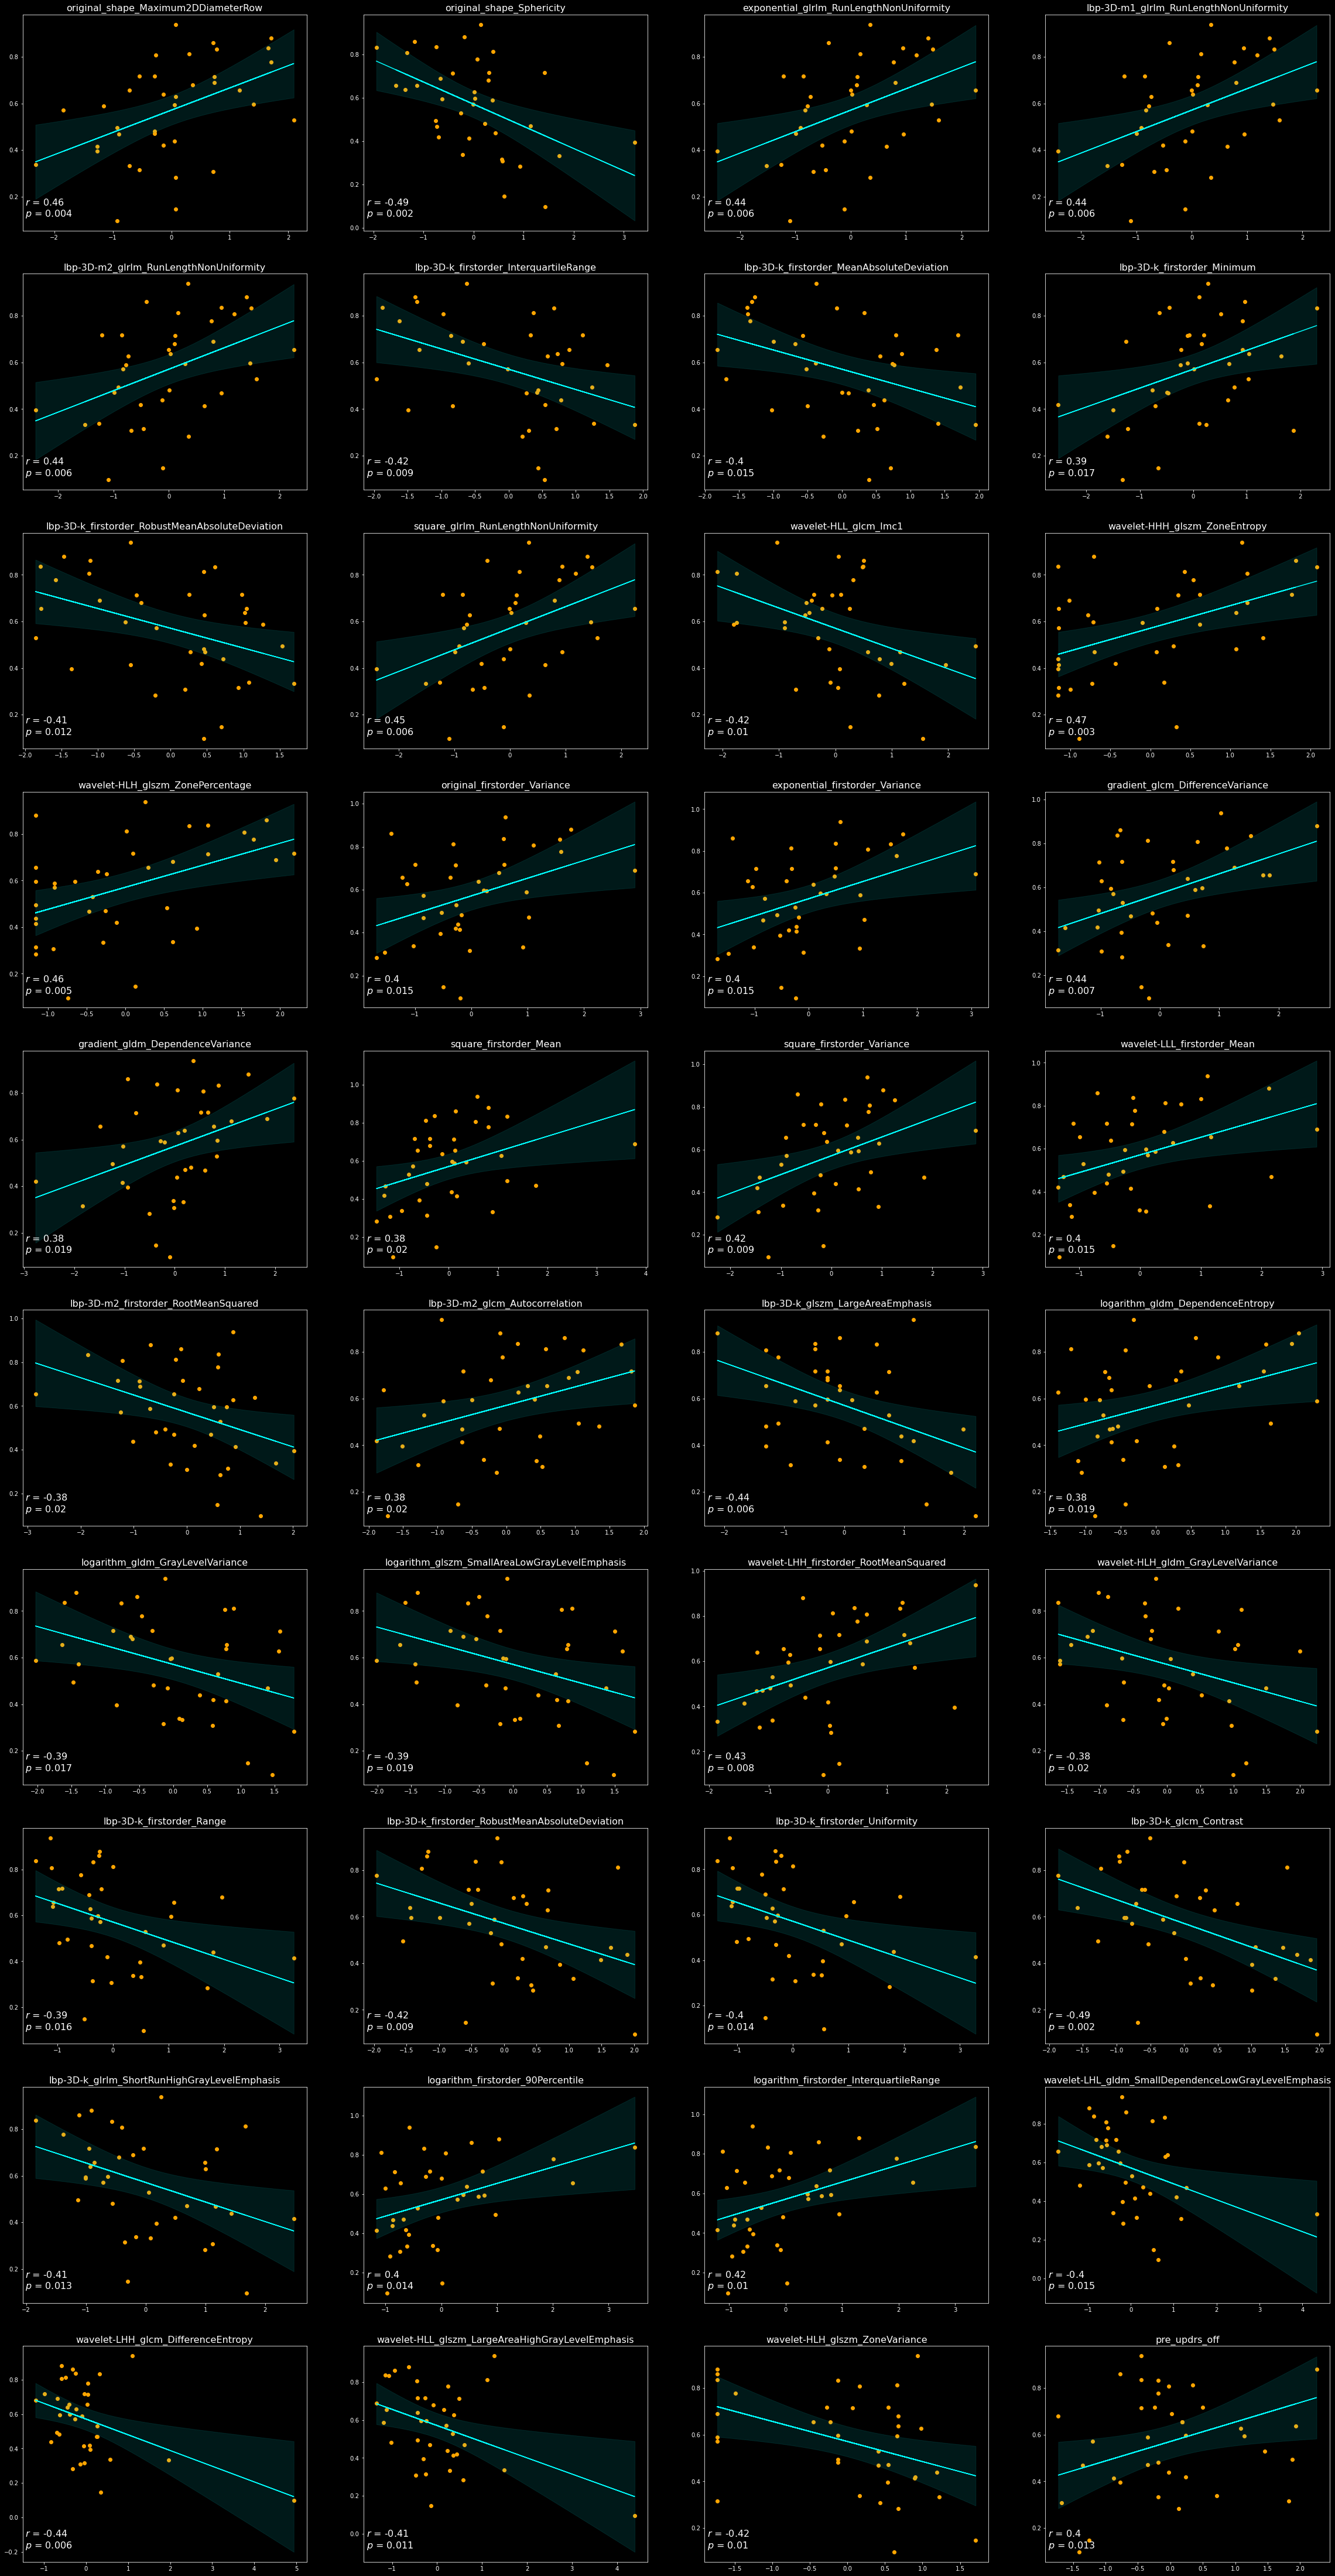

In [19]:
rcParams['figure.figsize'] = 40, 80
pc = 0
v = 0
nps = 40
rw = 10
viz = True
with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
  # Feature selection
    for k in np.arange(X0_ss0.shape[1]):
      if pc < nps:
        lr = stats.linregress(X0_ss0[:,k],per_change)
        try:
          if (abs(lr.rvalue)>0.35 and lr.pvalue < 0.02) or K[k]==K[-1]:
            if pc < nps-1:
              next
            else:
              k = -1
              print(K[k],np.round(lr.rvalue,3),np.round(lr.pvalue,5))
            y_model = X0_ss0[:,k]*lr.slope+lr.intercept
            if viz == True:
              v = v+1
              ax = plt.subplot(rw,nps//rw,v)
              ax.scatter(X0_ss0[:,k],per_change,color='orange')
              ax.plot(X0_ss0[:,k],y_model,color='cyan') 

            x = X0_ss0[:,k]
            y = per_change
            x_mean = np.mean(x)
            y_mean = np.mean(y)
            # number of samples
            n = x.size   
            # number of parameters: slope and intercept                     
            m = 2     
            # degrees of freedom                       
            dof = n-m  
            # statistic of interval confidence                       
            t = stats.t.ppf(0.975,dof)  
            # Standard deviation of the error
            residual_ut = y-y_model
            std_error = (np.sum(residual_ut**2)/dof)**(1/2)

            # Pearson's correlation coefficient
            numerator = np.sum((x-x_mean)*(y-y_mean))
            denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**(1/2)
            correlation_coef = numerator/denominator
            r = correlation_coef
            tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
            # p-value for 2-sided test
            pv = 2*(1-stats.t.cdf(abs(tr), dof))
            # mean squared error
            MSE = 1/n*np.sum((y-y_model)**2)
        
      
            x_line = np.linspace(np.min(x),np.max(x),len(x))
            y_line = x_line*lr.slope+lr.intercept
            ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**(1/2)
            ax.set_title(K[k],fontsize=16)
            ax.fill_between(x_line,y_line+ci,y_line-ci,color = 'cyan',label = '95% confidence interval',alpha=0.1)
            ax.text(0.01,0.05,'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(round(lr.pvalue,3)),
                    ha='left', va='bottom', transform=ax.transAxes,fontsize=16)   
            plt.style.use('dark_background')
            pc = pc+1
          else:
            next
        except:
            print('K index exceeded at:',k)

  

   


In [13]:
K.shape

(9571,)